# FX Trading Strategy: A Geometrical and Conditional Variance Approach.
#### Pablo Esparcia Casado
#### 25-09-2024


## Summary
In this case study, we have developed a quantitative strategy applicable to the main currency pairs. We have implemented conditional Bollinger Bands based on the EGARCH model for average price returns as an approximation to the market price. But we want to control the environment of the series, so we have implemented a measure based on the Euclidean distance of the volume dividing it by the ask volume and the bid volume between the current volumes and the volumes of the previous moment to anticipate fast movements. 
After describing the main strategy, we have tested it using a moving window of 500 observations with a frequency of 1 minute to dynamically calibrate the EGARCH, obtaining separately the Profit and Loss at each moment, and the Implicit Cost that arises from the spread.

**Outline**   
1. [Objective.](#id1)
2. [Data Collection.](#id2)                                                                                         
    2.1 [Data manipulation and cleaning.](#id3)                                                                                         
     2.1 [Data manipulation and cleaning.](#id3)                                                                                         
     2.3 [Exploratory Analysis of the studied currency pair.](#id4)
3. [Strategy Development](#id5)
4. [Strategy Implementation](#id6)
5. [Performance Evaluation. Backtest](#id7)
6. [Appendix](#id8)


## 1. Objective  <a name="id1"></a>
### The main objective is to generate and develop the basis for a profitable trading strategy.
The focus of the strategy is on highly liquid currency pairs such as EUR/USD, GBP/USD...
In terms of primary results, our aim is to lay the foundations of the strategy, with the next step being better calibration of the model or sophistication of the signal configuration.


## 2. Data Collection <a name="id2"></a>
We sourced historical spot rates with bid and ask prices from the Dukascopy data platform. Dukascopy Swiss Bank has a reiable data market repository, ensuring that the data was consistent and clean for analysis. The dataset includes high-frequency tick data.

*    Run he following code to open Dukascopy website:


In [42]:
from selenium import webdriver 
from selenium.webdriver.common.by import By  

driver = webdriver.Firefox()

driver.get("https://www.dukascopy.com/swiss/english/marketwatch/historical/")

driver.find_element(By.XPATH, value='/html/body/div[2]/div[2]/div[3]/div/div[1]').click() # Accepting cookies


The API used to download data is described in [githbub](https://github.com/giuse88/duka). For the currency pairs __EUR/USD__ and __EUR/GBP__ between __[2024-8-15]__ and __[2024-9-15]__ it is implemented as follows:

In [2]:
import duka.app.app as import_ticks_method
from duka.core .utils import TimeFrame
import datetime

import pandas as pd
import numpy as np


ccy = ["EURUSD"]
start_date = datetime.date(2024,7,15)
end_date = datetime.date(2024,9,15)


path="/Users/pablo/Downloads"


In [ ]:
import_ticks_method(ccy,start_date,end_date,1,TimeFrame.TICK,path,True)

### 2.1 Data manipulation and cleaning <a name="id3"></a>

After downloading the data, we created new variables such as spread, average price and return.
We also selected a frequency of 1 minute. We chose the last observation of each minute since the original data has a frequency of milliseconds and setting the time as index for convenience.


* $ spread(pips) = (ask - bid) \cdot 10000$
$$$$
* $ Mid Price_t = \frac{(ask + bid)}{2} $
$$$$
* $ Return_t = ln(Mid Price_t) - ln(Mid Price_{t-1})$


In [44]:
for i in range(0,len(ccy)):
    archive = ccy[i] +'-' + str(start_date).replace("-", "_") + "-" + str(end_date).replace("-", "_")+".csv"
    globals()[f"data_{ccy[i]}"] = pd.read_csv(f"{path}/{archive}")
    globals()[f"data_{ccy[i]}"]["time"] = pd.to_datetime(globals()[f"data_{ccy[i]}"]["time"])
    globals()[f"data_{ccy[i]}"].set_index('time', inplace=True)
    globals()[f"{ccy[i]}_1m"] = globals()[f"data_{ccy[i]}"].resample('1min').last()
    globals()[f"{ccy[i]}_1m"]['Spread'] = (globals()[f"{ccy[i]}_1m"]['ask']- globals()[f"{ccy[i]}_1m"]['bid'])*10000 
    globals()[f"{ccy[i]}_1m"]['MidPrice'] = (globals()[f"{ccy[i]}_1m"]['ask'] + globals()[f"{ccy[i]}_1m"]['bid'])/2
    globals()[f"{ccy[i]}_1m"]['Return'] = np.log(globals()[f"{ccy[i]}_1m"]['MidPrice']).diff()
    globals()[f"{ccy[i]}_1m"]['Dif_Spread'] = np.log(globals()[f"{ccy[i]}_1m"]['Spread']).diff()

EURUSD_1m.dropna(inplace= True)
EURUSD_1m.reset_index(inplace= True)

#EURGBP_1m.dropna(inplace= True)
#EURGBP_1m.reset_index(inplace= True)

### 2.3 Exploratory Analysis of the studied currency pair <a name="id4"></a>

We will focus the analysis and describe the EUR/USD as the currency pair of the strategy:

In [4]:
EURUSD_1m.describe()

,ask,bid,ask_volume,bid_volume,Spread,MidPrice,Return,Dif_Spread
count,64229.000000,64229.000000,6.422900e+04,6.422900e+04,64229.000000,64229.000000,6.422900e+04,64229.000000
mean,1.098432,1.098402,2.666973e+06,2.890736e+06,0.293302,1.098417,2.662773e-07,0.000355
std,0.010912,0.010911,3.241743e+06,2.719855e+06,0.366586,0.010911,9.078889e-05,0.467287
min,1.077790,1.077780,1.100000e+05,9.000000e+04,0.100000,1.077785,-2.432157e-03,-4.189655
25%,1.089430,1.089400,9.000000e+05,9.000000e+05,0.200000,1.089415,-3.686364e-05,-0.405465
50%,1.098460,1.098440,9.900000e+05,1.800000e+06,0.200000,1.098450,0.000000e+00,0.000000
75%,1.107880,1.107840,2.790000e+06,4.500000e+06,0.300000,1.107860,4.044371e-05,0.405465
max,1.120120,1.120080,3.960000e+07,3.105000e+07,12.800000,1.120100,3.469434e-03,4.077537


In [5]:
EURUSD_1m.head()

,time,ask,bid,ask_volume,bid_volume,Spread,MidPrice,Return,Dif_Spread
0,2024-07-15 00:01:00,1.08856,1.08855,900000.0,900000.0,0.1,1.088555,-0.000064,-1.098612
1,2024-07-15 00:02:00,1.08861,1.08858,1800000.0,1890000.0,0.3,1.088595,0.000037,1.098612
2,2024-07-15 00:03:00,1.08842,1.08839,900000.0,1890000.0,0.3,1.088405,-0.000175,0.000000
3,2024-07-15 00:04:00,1.08852,1.08849,3600000.0,900000.0,0.3,1.088505,0.000092,0.000000
4,2024-07-15 00:05:00,1.08853,1.08849,9540000.0,1800000.0,0.4,1.088510,0.000005,0.287682


It is important to note that the volume variable is in millions and is a sign of the high liquidity of this market. Also, compared to the ask and bid it has a higher standard deviation along with the spread.
Without the need to do an augmented Dicky Fuller test for stationarity we know that prices are not stationary, therefore we will use the logarithmic return of the mean price.

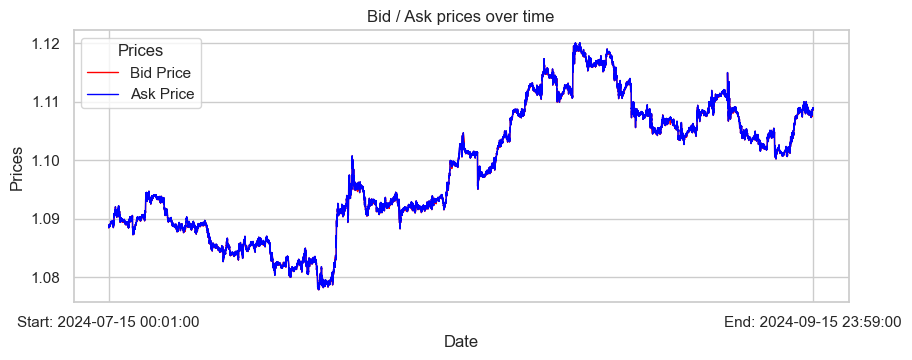

In [8]:
fig1(EURUSD_1m)

As can be seen, the series has very small differences between the bid and ask prices throughout the month. The differences between the maximum price and the minimum price are decimal place, which indicates that the strategy would suggest obtaining small differences, hence the importance of taking into account the implicit cost of each transaction.

As part of the exploratory analysis we can sobserve for a given day how the spread behaves:

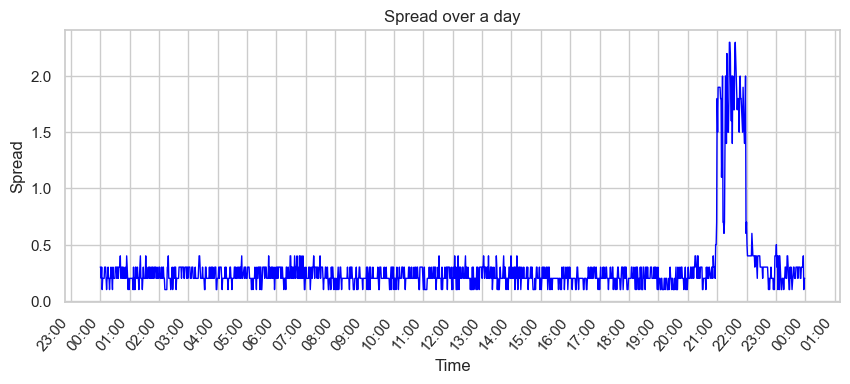

In [9]:
fig2(EURUSD_1m, date= "2024-08-27")

Over the days we can observe the same pattern, the spread increases at the same hours.

## 3. Strategy Development <a name="id5"></a>


### Signals 

To generate a signal we want to control by volume. To do that, we are going to use the Euclidian Distance between the ask and bid volume in the current period and that volume in the last observation:

$$
\text{Distance}_t = \sqrt{(\text{ask_volume}_{t-1} - \text{bid_volume}_{t-1})^2 + (\text{ask_volume}_t - \text{bid_volume}_t)^2}
$$

The main rationale is that a large distance imply a quick change in the market, so, we will enter into the a potential transaction if the absolute change in the distance is above the historical mean of the distances.


The strategy uses conditional volatility to define trading bands based on a multiple of the estimated volatility. The trading bands (*upper bound* and *lower bound*) are defined as follows:

$$
\text{Upper Bound}_t = 1.65 \times \sqrt h_t
$$

$$
\text{Lower Bound}_t = -1.65 \times \sqrt h_t
$$

We are using the parameter 1.65 as the 90% confidence level mantainig a 5% of significance leve on each side. 

When the return exceeds the upper band, a **sell** signal is issued, and when the return falls below the lower band, a **buy** signal is issued. Signals are defined as:
$$
\text{Signal}_t =
\begin{cases} 
      1 & \text{if } \text{Return}_t \leq \text{Lower Bound}_t \quad \text{(Buy)} \\
      -1 & \text{if } \text{Return}_t \geq \text{Upper Bound}_t \quad \text{(Sell)} \\
      0 & \text{Otherwise} 
   \end{cases}
$$


###  EGARCH model 

To model the conditional volatility of returns, an **EGARCH (Exponential Generalized Autoregressive Conditional Heteroskedasticity)** model is used. The EGARCH model captures the asymmetry and non-linearity in volatility, and its specification is as follows:

$$
ln(h_t) = \omega + \sum^{p}_{i=1}\alpha_i\hspace{0.05 cm}g(z_{t-1}) + \sum^{q}_{j=1}\hspace{0.05 cm}\beta_i \hspace{0.1 cm}ln(h_{t-j})
$$

$ g(z_{t}) = \theta\cdot z_t + \gamma[|z_t| - E|z_t|]\hspace{0.05 cm} $
$ z_{t} = \frac{\varepsilon_t}{\sqrt{h_t}}\hspace{0.05 cm} $


Where $\theta$ and $\gamma$ are the parameters controlling the asymmetry within the function $g(z_t)$. Noting the distribution of the absolute z_t is the so called Half-Normal, the expected value of the absolute z_t is: 
$ E|z_t| = \sqrt{\frac{2}{\pi}} $

Putting all together:
$
    ln(h_t) = \omega + \sum^{p}_{i=1}\alpha_i\hspace{0.05 cm} \left[ \theta z_{t-i} + \gamma \left( |z_{t-i}| -\sqrt{\frac{2}{\pi}} \right ) \right] + \sum^{q}_{j=1}\beta_i \hspace{0.1 cm}ln(h_{t-j}) 
$

The model selects the number of lags p and q that minimizes the Akaike Information Criterion (AIC).

### Closing Positions 

We consider a closing position when we have the opposite signal, which imply opening the new position in the direction fof the new signal.



## 4. Strategy Implementation <a name="id6"></a>

To implement the strategy I used a rolling window of size 500 to calibrate the GARCH model and apply the rules described above.

The first step is to create a funcion to construct the model. where "o" is the number of lags of the assymetry parameter, and combining the different type of lags:

In [7]:
from arch import arch_model

def setting_egarch(data,p_max,q_max,o):
    best_aic = np.inf
    best_order = None
    best_model_garch = None

    for p in range(1, p_max):
        for q in range(1, q_max):
            model_garch = arch_model((data['Return']), vol='Egarch', p=p, q=q,o=o)
            model_garch_fit = model_garch.fit(disp="off")
            aic = model_garch_fit.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (p, q)
                best_model_garch = model_garch_fit
    return best_aic, best_order, best_model_garch


Once we have the conditional volatility, we can implement the strategy. I have decied 500 for the rolling window as any other reasonable quantity. We proceed with the calculation in each iteration the magnitude varible whcih gathers the euclidian distance. That Magnitude is integrated using logarithmics to observe the change. Due to the large number of observations, we are going to focus on the historical data of the first day that is approximatelly 1400 observations.

In [52]:
EURUSD_1m = EURUSD_1m2

In [53]:
EURUSD_1m = EURUSD_1m[EURUSD_1m['time'].dt.strftime('%Y-%m-%d') == "2024-08-20"]
EURUSD_1m.reset_index(inplace=True)
EURUSD_1m.head()

,index,time,ask,bid,ask_volume,bid_volume,Spread,MidPrice,Return,Dif_Spread
0,37159,2024-08-20 00:00:00,1.10863,1.10861,900000.0,3600000.0,0.2,1.108620,0.000059,-0.405465
1,37160,2024-08-20 00:01:00,1.10870,1.10868,2700000.0,900000.0,0.2,1.108690,0.000063,0.000000
2,37161,2024-08-20 00:02:00,1.10860,1.10857,900000.0,3600000.0,0.3,1.108585,-0.000095,0.405465
3,37162,2024-08-20 00:03:00,1.10863,1.10861,900000.0,900000.0,0.2,1.108620,0.000032,-0.405465
4,37163,2024-08-20 00:04:00,1.10867,1.10863,5940000.0,6750000.0,0.4,1.108650,0.000027,0.693147


In [ ]:

end_loc = 500
signal_volume = []
signal_total = []
n_d = pd.DataFrame()
magnitude = pd.DataFrame()


for i in range(0,700-end_loc):
    
    best_aic, best_order, best_model_garch = setting_egarch(EURUSD_1m[i:end_loc+i], p_max=4, q_max=4, o=1)
    
    magnitude.loc[i,'Distance'] = np.sqrt((EURUSD_1m.loc[end_loc+i-1,'ask_volume']-
                                           EURUSD_1m.loc[end_loc+i-1,'bid_volume'])**2 +
                                          (EURUSD_1m.loc[end_loc+i,'ask_volume'] -
                                           EURUSD_1m.loc[end_loc+i,'bid_volume'])**2) #
    
    if i==0:
        magnitude.loc[i,'Distance_diff'] = 0
    
    else:
        magnitude.loc[i,'Distance_diff'] = (magnitude.loc[i,'Distance'] - magnitude.loc[i-1,'Distance'])
   
    
    
    n_d.loc[i,'Return'] = EURUSD_1m.loc[end_loc+i,'Return']
    n_d.loc[i,'MidPrice'] = EURUSD_1m.loc[end_loc+i,'MidPrice']

    n_d.loc[i,'time'] = EURUSD_1m.loc[end_loc+i,'time']
    n_d.loc[i,'conditional_volatility'] = best_model_garch.conditional_volatility.iloc[end_loc-1]

  
    l_bound = -1.65*n_d.loc[i,'conditional_volatility']
    u_bound =  1.65*n_d.loc[i,'conditional_volatility'] 
    n_d.loc[i,'l_bound']= l_bound
    n_d.loc[i,'u_bound']= u_bound
'''
Movement above or below the historical mean. 
As an example I have choosen 10000 because the mean was around 9900    
'''
    if np.abs(magnitude.loc[i,'Distance_diff']) > 10000: 
       
       
        if float(n_d.loc[i,'Return']) <= float(l_bound): #Buy: changed sel
           n_d.loc[i,'Signal'] = 1
           n_d.loc[i,'Transaction_Ask'] = EURUSD_1m.loc[end_loc+i,'ask']  
           n_d.loc[i,'Transaction_Bid'] = 0
           signal_volume.append(1) 
           
        elif float(n_d.loc[i,'Return']) >= float(u_bound): #Sell: chagned buy
           n_d.loc[i,'Transaction_Ask'] = 0
           n_d.loc[i,'Transaction_Bid'] = EURUSD_1m.loc[end_loc+i,'bid'] 
           n_d.loc[i,'Signal'] = -1
           signal_volume.append(1) 
        else:
           n_d.loc[i,'Signal'] = 0
           signal_volume.append(0) 
           n_d.loc[i,'Transaction_Ask'] = 0
           n_d.loc[i,'Transaction_Bid'] = 0
    else: 
        n_d.loc[i,'Signal'] = 0
        n_d.loc[i,'Transaction_Ask'] = 0
        n_d.loc[i,'Transaction_Bid'] = 0
        signal_volume.append(0) 
    
    n_d.loc[i,'Ask'] = EURUSD_1m.loc[end_loc+i,'ask']
    n_d.loc[i,'Bid'] = EURUSD_1m.loc[end_loc+i,'bid'] 
        

In [55]:
n_d.head(10)

,Return,MidPrice,time,conditional_volatility,l_bound,u_bound,Signal,Transaction_Ask,Transaction_Bid,Ask,Bid
0,-0.000108,1.108080,2024-08-20 08:22:00,4.480471e-06,-7.392778e-06,7.392778e-06,0.0,0.0,0.00000,1.10809,1.10807
1,0.000027,1.108110,2024-08-20 08:23:00,6.020464e-07,-9.933766e-07,9.933766e-07,-1.0,0.0,1.10810,1.10812,1.10810
2,0.000086,1.108205,2024-08-20 08:24:00,9.173003e-08,-1.513546e-07,1.513546e-07,-1.0,0.0,1.10819,1.10822,1.10819
3,-0.000162,1.108025,2024-08-20 08:25:00,1.098005e-05,-1.811709e-05,1.811709e-05,0.0,0.0,0.00000,1.10804,1.10801
4,-0.000158,1.107850,2024-08-20 08:26:00,1.188148e-04,-1.960445e-04,1.960445e-04,0.0,0.0,0.00000,1.10786,1.10784
5,0.000027,1.107880,2024-08-20 08:27:00,3.885855e+00,-6.411661e+00,6.411661e+00,0.0,0.0,0.00000,1.10789,1.10787
6,0.000117,1.108010,2024-08-20 08:28:00,1.358744e-02,-2.241928e-02,2.241928e-02,0.0,0.0,0.00000,1.10802,1.10800
7,-0.000135,1.107860,2024-08-20 08:29:00,1.870375e-03,-3.086119e-03,3.086119e-03,0.0,0.0,0.00000,1.10787,1.10785
8,0.000099,1.107970,2024-08-20 08:30:00,1.990627e-04,-3.284534e-04,3.284534e-04,0.0,0.0,0.00000,1.10798,1.10796
9,0.000099,1.108080,2024-08-20 08:31:00,1.088503e-05,-1.796030e-05,1.796030e-05,-1.0,0.0,1.10807,1.10809,1.10807


In [ ]:
n_d.groupby('Signal').mean()[['MidPrice','Transaction_Ask','Transaction_Bid','conditional_volatility']]

Grouping by signal (-1 sell and 1 buy) we can find that when such positions are taken, volatility is really low. While selling is done on average at a lower average price and buying the average price is higher. Which is something we would expect from a reliable strategy. 


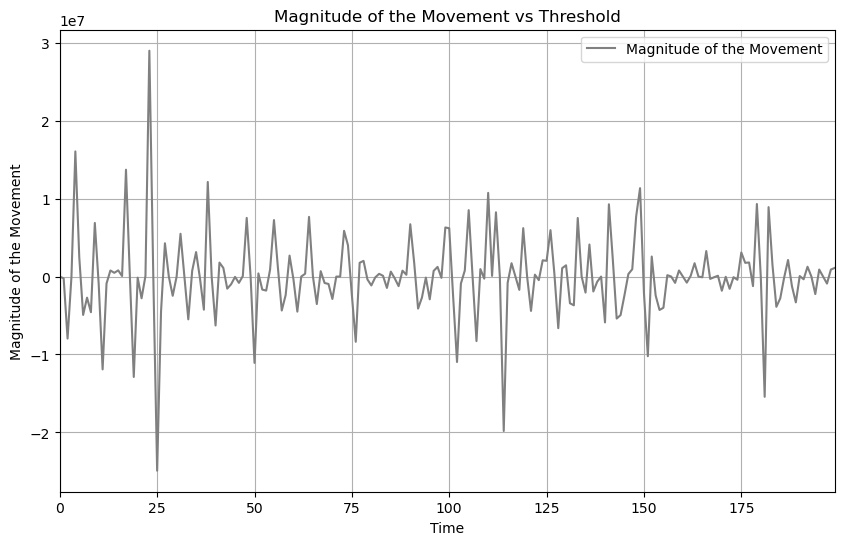

In [19]:
fig6(magnitude)

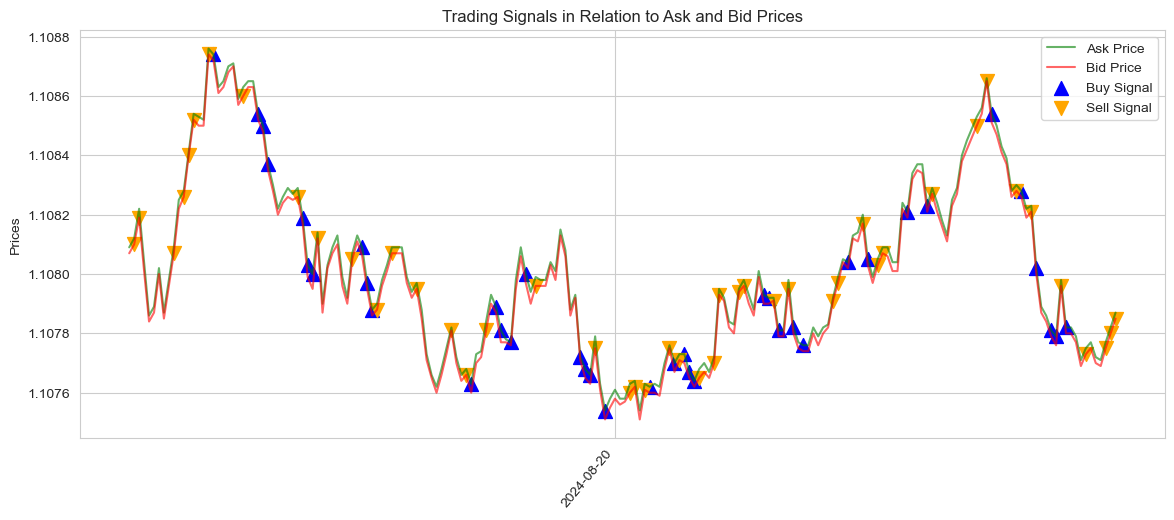

In [57]:
fig5(n_d)

## 5. Performance Evaluation and Backtest <a name="id7"></a>

Given the signals, we relaxes the condition that signals that are followed by signals from the same sign increase the position. For simplicity we just focus on the change of positions.

For the calculation of the return and implicit cost we are going to consider for a long position:

$$\text{Gross Return} = \frac{\text{MidPrice}_{\text{close}} - \text{MidPrice}_{\text{open}}}{\text{MidPrice}_{\text{open}}}$$

$$\text{Implicit Cost} = \frac{\text{MidPrice}_{\text{close}} - \text{Bid}_{\text{close}}}{\text{MidPrice}_{\text{close}}} + \frac{\text{Ask}_{\text{open}} - \text{MidPrice}_{\text{open}}}{\text{MidPrice}_{\text{open}}} $$



In [58]:


import pandas as pd

position = 0  
entry_price = 0  
entry_midprice = 0
pnl = 0  
ret = 0  
acc_spread = 0
implicit_cost = 0  
transaction =0

pnl_history = []
cost_history = []
ret_history = []
spread_history = []
transaction_history = []

for index, row in n_d.iterrows():
    signal = row['Signal']
    ask = row['Ask']
    bid = row['Bid']
    midPrice = row['MidPrice']
    #settle = row['Settle']
    
   
    if position != 0:    # If open position:
        #  If a contrary signal appears, close position and open new one
        if (signal == 1 and position < 0) or (signal == -1 and position > 0): 
            
            if position > 0:  # Close buy (long) at Bid price
                pnl += position * (bid - entry_price)
                acc_spread += position * (midPrice-bid)
                implicit_cost = (midPrice-bid)/midPrice + (entry_price-entry_midprice)/entry_midprice
                ret = (midPrice-entry_midprice)/entry_midprice
            else:  # Close sale (short) at Ask price
                pnl += -position * (entry_price - ask)
                acc_spread += -position * (ask-midPrice)
                implicit_cost = (ask-midPrice)/midPrice + (entry_price-entry_midprice)/entry_midprice
                ret = -(midPrice-entry_midprice)/entry_midprice   
        
            transaction =1 
                
            # Open new position according to the new signal
            position = signal
            entry_price = ask if signal == 1 else bid  
            entry_midprice = midPrice
            acc_spread += (ask - midPrice) if signal == 1 else (midPrice - bid)
        else:
            transaction = 0
            
   
    if position == 0 and signal != 0: # If there is no open position and a signal is received to open one
        position = signal
        entry_price = ask if signal == 1 else bid  
        entry_midprice = midPrice
       
        acc_spread += (ask - midPrice) if signal == 1 else (midPrice - bid)
        
    pnl_history.append(pnl)
    cost_history.append(implicit_cost)
    ret_history.append(pnl)
    spread_history.append(implicit_cost)
    transaction_history.append(transaction)


n_d['PnL'] = pnl_history
n_d['ImplicitCost'] = cost_history
n_d['Gross_Return'] = ret_history
n_d['Spread_acc'] = spread_history
n_d['Transaction'] = transaction_history


Here we can observe the general result of the transactions, where the Net Return is the return after consider the implicit cost:

In [59]:
n_d['Net_Return']= n_d['Gross_Return'] -n_d['ImplicitCost']
n_d_transacts=n_d[n_d['Transaction']==1][['Signal', 'Ask', 'Bid', 'MidPrice','Gross_Return', 
                                          'ImplicitCost','Net_Return']]
table = pd.DataFrame({
    'Type': ['Total Transactions', 'Positive Net Returns', 'Positive Gross Returns'],
    'Count': [(n_d['Transaction'] == 1).sum(), 
              ((n_d['Net_Return'] > 0) & (n_d['Transaction'] == 1)).sum(), 
              ((n_d['Gross_Return'] > 0) & (n_d['Transaction'] == 1)).sum()] })



n_d[n_d['Transaction']==1][['Signal', 'Ask', 'Bid', 'MidPrice','Gross_Return', 
                            'ImplicitCost','Net_Return']]

,Signal,Ask,Bid,MidPrice,Gross_Return,ImplicitCost,Net_Return
17,1.0,1.10874,1.10872,1.108730,-0.00064,-5.046415e-09,-0.000640
23,-1.0,1.10863,1.10860,1.108615,-0.00078,2.254972e-05,-0.000803
26,1.0,1.10854,1.10852,1.108530,-0.00072,-4.509440e-06,-0.000715
34,-1.0,1.10829,1.10826,1.108275,-0.00100,2.255550e-05,-0.001023
35,1.0,1.10819,1.10817,1.108180,-0.00093,-4.510742e-06,-0.000925
38,-1.0,1.10814,1.10812,1.108130,-0.00100,1.804802e-05,-0.001018
47,1.0,1.10809,1.10806,1.108075,-0.00097,4.512778e-06,-0.000975
50,-1.0,1.10790,1.10788,1.107890,-0.00118,2.256316e-05,-0.001203
69,1.0,1.10763,1.10760,1.107615,-0.00093,4.516445e-06,-0.000935
72,-1.0,1.10784,1.10781,1.107825,-0.00075,2.708266e-05,-0.000777


In [60]:
table

,Type,Count
0,Total Transactions,42
1,Positive Net Returns,2
2,Positive Gross Returns,4


As we can observe, the big majority of the transactions arises a negative return. 

## Cumulative Returns

The profitability of the strategy is calculated by multiplying the signals emitted by the returns at each instant:

$$
\text{Returns Signal}_t = \text{Signal}_t \times \text{Return}_t
$$

Finally, the cumulative return is calculated as:

$$
\text{Cumulative Returns}_t = \prod_{i=1}^{t} \left(1 + \text{Returns Signal}_i \right)
$$

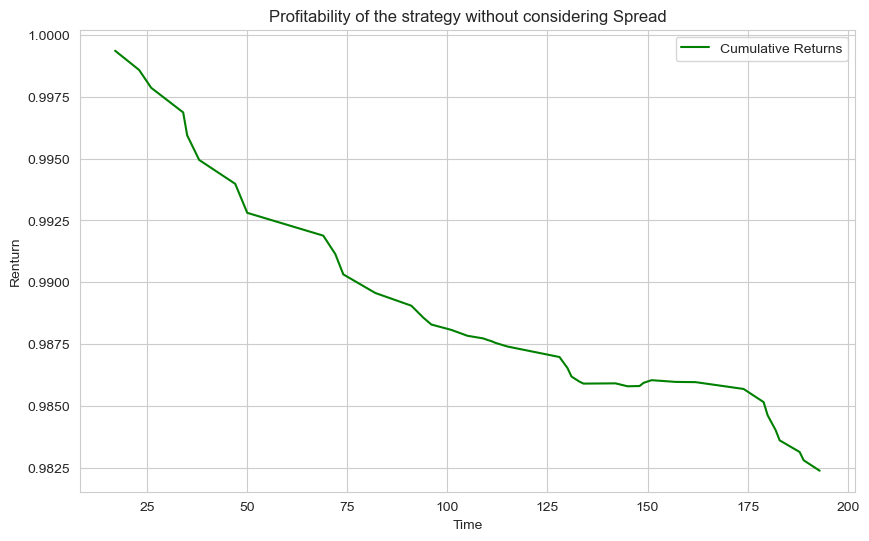

In [61]:
fig4(n_d_transacts)

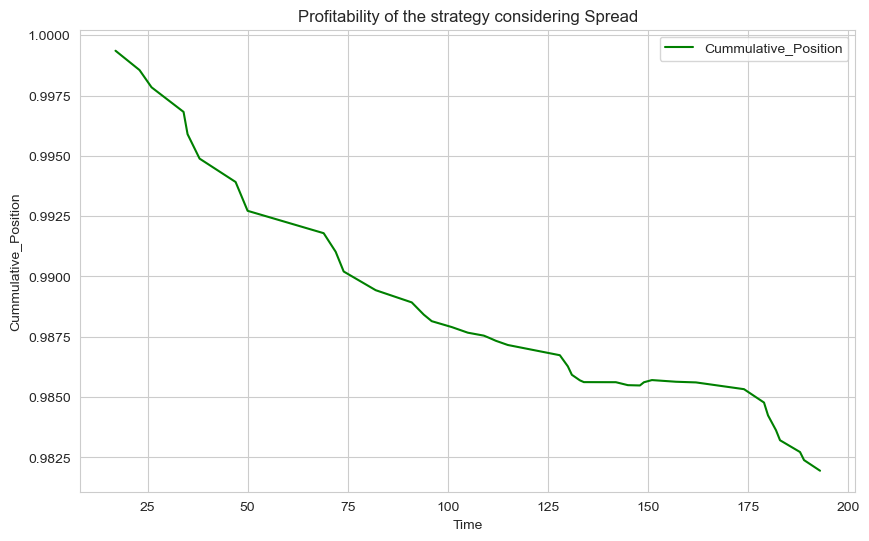

In [62]:
fig4_1(n_d_transacts)

From the graphs above we can see that the return is mainly negative, and give as a position below 1, the spread increments a little bit the loss. 
This backtest must take into account the risks, so the Historic **VaR** and **ES** are calculated:

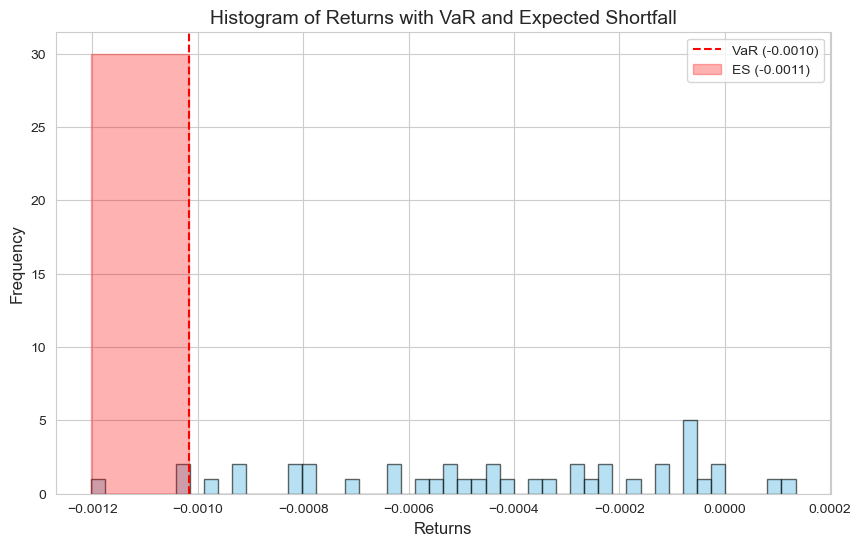

In [63]:
VaR_ES(n_d_transacts, 0.05)

As we can observe it is highly assymetrical.

## 6. Appendix <a name="id8"></a>

In [17]:

######## Graphs ########

import seaborn as sns
import matplotlib.dates as mdates  
import matplotlib.pyplot as plt

def fig1(data):   
    
      
    data = data.reset_index()

    plt.figure(figsize=(10, 4))
    sns.set_theme(font_scale=1, rc={"axes.spines.right": False, "axes.spines.top": False})
    sns.set_style("whitegrid")
    #sns.set_context("talk")

    plt.gcf().autofmt_xdate()

    sns.lineplot(data=data, x='index', y='bid', color="red", lw=1, markers="o", markersize=2, 
                 label="Bid Price")
    sns.lineplot(data=data, x='index', y='ask', color="blue", lw=1, markers="o", markersize=2, 
                 label="Ask Price")
    plt.legend(title='Prices')
   
    first_label = "Start: " + str(data['time'].iloc[0])
    last_label = "End: " + str(data['time'].iloc[-1])
    
    
    plt.xticks([data.index[0],data.index[-1]], [first_label, last_label])
    
    plt.title("Bid / Ask prices over time")
    plt.xlabel("Date")
    plt.ylabel("Prices")
    plt.grid(True)
    plt.show()

    
    
def fig2(data, date):
    plt.figure(figsize=(10, 4))
    sns.set_theme(font_scale=1, rc={"axes.spines.right": False, "axes.spines.top": False})
    sns.set_style("whitegrid")
    

    data_specific_day = data[data['time'].dt.strftime('%Y-%m-%d') == date]

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
    

   
    plt.gcf().autofmt_xdate(rotation=50, ha='right')  

    sns.lineplot(data_specific_day, x='time', y='Spread', color="blue", 
                 lw=1, markers="o", markersize=2)


    plt.title("Spread over a day")
    plt.xlabel("Time")
    plt.ylabel("Spread")
    plt.grid(True)
    plt.show()

    
    
    
    
def fig3(data,model_fitted):
    df = pd.DataFrame()
    df['conditional_volatility'] = model_fitted.conditional_volatility
    df['Dif_Spread']= data['Dif_Spread']
    df['Return']= data['Return']
    sns.set_style("whitegrid")
    fig, ax1 = plt.subplots(figsize=(10,6))

    
    color = 'tab:blue'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Return', color=color)
    ax1.plot(df['Return'], color=color, alpha=0.5)
    ax1.tick_params(axis='y', labelcolor=color)

    
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Conditional Volatility', color=color)
    ax2.plot(df['conditional_volatility'], color=color, linewidth=2)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  
    plt.title('Returns and Conditional Volatility (Eje Doble)')
    plt.show()
   
    
def fig4(data):
    data['Returns_Signal'] =  data['Gross_Return']
    data['Cumulative_Returns'] = (1 + data['Returns_Signal']).cumprod()
    sns.set_style("whitegrid")
    plt.figure(figsize=(10,6))
    plt.plot(data['Cumulative_Returns'], label='Cumulative Returns', color='green')

    plt.title('Profitability of the strategy without considering Spread')
    plt.xlabel('Time')
    plt.ylabel('Renturn')
    plt.legend()
    plt.grid(True)
    plt.show()  

    
def fig4_1(data):
    data['Returns_Signal'] = data['Net_Return']
    data['Cummulative_Position'] = (1 + data['Returns_Signal']).cumprod()
    sns.set_style("whitegrid")
    plt.figure(figsize=(10,6))
    plt.plot(data['Cummulative_Position'], label='Cummulative_Position', color='green')

    plt.title('Profitability of the strategy considering Spread')
    plt.xlabel('Time')
    plt.ylabel('Cummulative_Position')
    plt.legend()
    plt.grid(True)
    plt.show()  

def fig5(data):

    plt.figure(figsize=(14, 6))
    plt.plot(data['time'], data['Ask'], label='Ask Price', color='green', alpha=0.6)
    plt.plot(data['time'], data['Bid'], label='Bid Price', color='red', alpha=0.6)

    sns.set_style("whitegrid")
    buy_signals = data[data['Signal'] == 1]
    sell_signals = data[data['Signal'] == -1]
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
 
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))
    plt.gcf().autofmt_xdate(rotation=50, ha='right') 
    
    
    plt.scatter(buy_signals['time'], buy_signals['Ask'], marker='^', color='blue', 
                label='Buy Signal', alpha=1, s=100)
    plt.scatter(sell_signals['time'], sell_signals['Bid'], marker='v', color='orange', 
                label='Sell Signal', alpha=1, s=100)


    plt.title('Trading Signals in Relation to Ask and Bid Prices')

    plt.ylabel('Prices')
    plt.legend(loc='best')
    plt.grid(True)

    plt.show()

def fig6(magnitude):
    plt.figure(figsize=(10,6))

    plt.plot(magnitude['Distance_diff'], label='Magnitude of the Movement', color='gray')

    plt.title('Magnitude of the Movement vs Threshold')
    plt.xlabel('Time')  
    plt.ylabel('Magnitude of the Movement')

    plt.xlim(magnitude.index.min(), magnitude.index.max()) 
    plt.legend()
    plt.grid(True)
    plt.show()



In [18]:

################ Risk Measures ###############
def VaR_ES (data, a):
    
    returns = data['Net_Return']

    VaR = np.percentile(returns, a * 100)

    ES = returns[returns < VaR].mean()

    plt.figure(figsize=(10, 6))


    plt.hist(returns, bins=50, alpha=0.6, color='skyblue', edgecolor='black')

    plt.axvline(x=VaR, color='r', linestyle='--', label=f'VaR ({VaR:.4f})')


    plt.fill_betweenx([0, 30], x1=returns.min(), x2=VaR, color='red', alpha=0.3, label=f'ES ({ES:.4f})')


    plt.title('Histogram of Returns with VaR and Expected Shortfall', fontsize=14)
    plt.xlabel('Returns', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)


    plt.legend()

    plt.show()
